# 10-1. 인물사진 모드란?

# 10-2. 셸로우 포커스 만들기 (1) 사진을 준비하자

### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/E-14-2.max-800x600_jKvxGUl.png)

두개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야함.  
이미지 세그멘테이션 기술을 사용하면 하나의 이미지에서 배경과 사람을 분리할 수 있음  
분리된 배경을 블러 처리 후 사람 이미지와 다시 합치면 아웃포커싱효과를 적용한 인물사진을 얻을 수 있음  
1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성 합니다.

In [1]:
# !pip install opencv-python

In [2]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # 웹에서 데이터를 다운바등ㄹ 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [3]:
# 준비한 이미지 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/h1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(999, 800, 3)


# 10-3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/E-14-4.max-800x600_9yTzEff.png)

렌즈 흐림 효과를 주기 위해 사람과 피사체를 분리해야함

# 세그멘테이션(Segmentation)이 뭔가요?
#### 이미지에서 픽셀 단위로 객체를 추출하는 방법
#### 이미지 세그멘테이션은 모든 픽셀에 라벨을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정함  

### 시멘틱 세그멘테이션(semantic segmentation)이란?
- 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션  
- 쉽게 말하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법
- "사람"이라는 추상적인 정보를 이미지에서 추출해내는 방법
- 그래서 사람이 누구인지 관계없이 같은 라벨로 표현 됨
![img](https://aiffelstaticprd.blob.core.windows.net/media/images/E-14-5.max-800x600_YNvIU7P.png)

### 인스턴스 세그멘테이션(Instance segmentation)이란?
- 시맨틱 세그멘테이션은 사람이란 추상적인 정보로 이미지를 추출해내므로 사람이 누구인지 관계없이 같은 라벨로 표현 되는데
- 인스턴스 세그멘테이션은 사람 개개인 별로 다른 라벨을 갖지게 함
- 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하는 것이 목표

Q2. 인스턴스 세그멘테이션 데이터셋과 라벨이 존재하면 시맨틱 세그멘테이션을 학습시킬 수 있을까요?

인스턴스의 id 뿐만이 아닌 클래스 라벨이 존재해야 시맨틱 세그멘테이션으로 학습이 가능합니다. 근본적으로는 다른 개념이지만 대부분의 데이터셋은 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재합니다.

### 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션(watershed segmentation)
  
이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것.  
경계를 나누는 방법은 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가지는데 이때 픽셀 값을 이용해 높고 낮음을 구분할 수 있음.  
낮은 부분부터 서서히 '물'을 채워나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생긴다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게됨


# 10-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
  
세그메테이션 문제에는 FCN, SegNet, U-Net등 많은 모델이 사용됨. 그중 DeepLab을 사용해서 만들 것  
DeepLab알고리즘(DeepLab v3+)는 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있음
https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

Q3. DeepLab에서  atrous convolution을 사용한 이유가 무엇인가요?

receptive field를 넓게 사용하기 위해 사용합니다. (적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해)



Q4. Depthwise separable convolution은 어디서 처음 사용한 것 일까요? 왜 이 구조가 효율적일까요?

Xception에서 제안되었습니다. 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적입니다.

In [4]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
# preprocess() 전처리, run() 실제로 세그멘테이션하는 함수
# 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리함
# 모델이 받는 입력 크기가 정해져있으므로 이에 따라 적절한 크기로 resize하고 OpenCV의 디폴트 BGR채널순서를 탠서플로우에 맞는 RGB로 수정
# 전처리 된 이미지는 run() 함수에서 사용되는 것을 볼 수 있음

(편집자 주)
AIFFEL의 딥러닝 관련 코드는 Tensorflow V2 기준으로 작성되지만, 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델구조를 그대로 가져와 활용하면서, Tensorflow V2에서 V1 코드와 모델구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용하고 있습니다. 그래서 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있습니다.
Tensorflow V1에서 작성된 수많은 레거시 코드들을 활용하려면 어떻게 해야 하는지를 학습하는 의미에서 Tensorflow V2 코드와 비교해 가면서 보기를 바랍니다.

In [5]:
# 사전에 학습된 가중치(pretrained weight)를 불러 옵니다. 구글에서 제공하는 파일을 다운로드 하겠습니다. 
# "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있으니 당황하지마세요!

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj47/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(999, 800, 3) (513, 410, 3) 19


In [7]:
# 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)



21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해 볼까요?



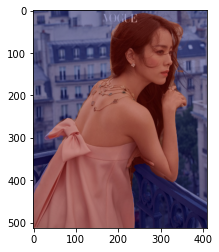

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

# 10-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기


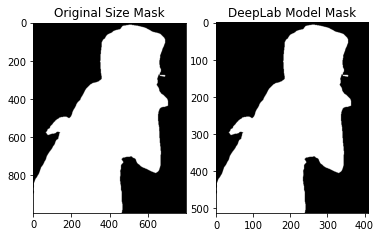

In [9]:
# DeepLab모델을 사용하기 위해 이미지 크기를 작게 resize했음. 따라서 출력도 resize된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
# 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻음
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

# 10-6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

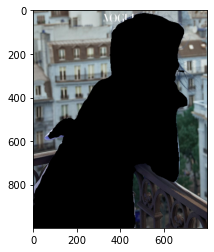

In [10]:
# 배경을 흐리게 하기 위해 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

# bitwise_not 함수를 이용하면 이미지가 반전됨
# 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.



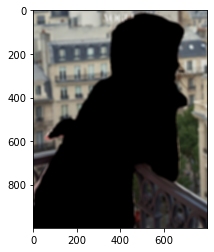

In [11]:
# 위 이미지를 불러와 배경이 흐리게 처리된 영상을 얻을 수 있음 

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 10-7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

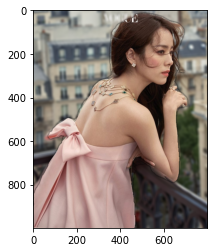

In [12]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

---

In [13]:
# !pip install opencv-python

In [14]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # 웹에서 데이터를 다운바등ㄹ 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [15]:
# 준비한 이미지 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/h2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(999, 800, 3)


# 10-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
  
세그메테이션 문제에는 FCN, SegNet, U-Net등 많은 모델이 사용됨. 그중 DeepLab을 사용해서 만들 것  
DeepLab알고리즘(DeepLab v3+)는 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있음
https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

In [16]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
# preprocess() 전처리, run() 실제로 세그멘테이션하는 함수
# 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리함
# 모델이 받는 입력 크기가 정해져있으므로 이에 따라 적절한 크기로 resize하고 OpenCV의 디폴트 BGR채널순서를 탠서플로우에 맞는 RGB로 수정
# 전처리 된 이미지는 run() 함수에서 사용되는 것을 볼 수 있음

In [17]:
# 사전에 학습된 가중치(pretrained weight)를 불러 옵니다. 구글에서 제공하는 파일을 다운로드 하겠습니다. 
# "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있으니 당황하지마세요!

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj47/aiffel/human_segmentation/models
model loaded successfully!


### 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션(watershed segmentation)
  
이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것.  
경계를 나누는 방법은 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가지는데 이때 픽셀 값을 이용해 높고 낮음을 구분할 수 있음.  
낮은 부분부터 서서히 '물'을 채워나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생긴다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게됨


In [18]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(999, 800, 3) (513, 410, 3) 15


In [19]:
# 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)



21

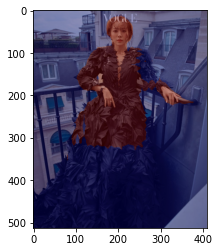

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 10-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기


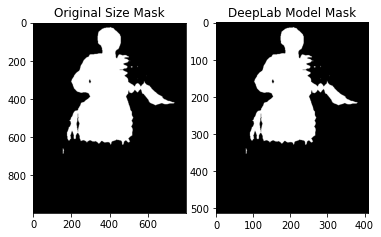

In [21]:
# DeepLab모델을 사용하기 위해 이미지 크기를 작게 resize했음. 따라서 출력도 resize된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
# 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻음
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

# 10-6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

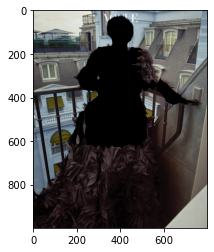

In [22]:
# 배경을 흐리게 하기 위해 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

# bitwise_not 함수를 이용하면 이미지가 반전됨
# 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.



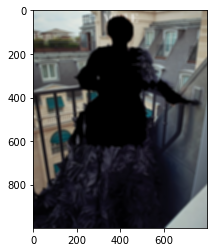

In [23]:
# 위 이미지를 불러와 배경이 흐리게 처리된 영상을 얻을 수 있음 

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 10-7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

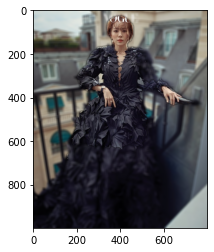

In [24]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

In [26]:
# !pip install opencv-python

In [27]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # 웹에서 데이터를 다운바등ㄹ 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [28]:
# 준비한 이미지 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/h3.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(499, 800, 3)


In [29]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
# preprocess() 전처리, run() 실제로 세그멘테이션하는 함수
# 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리함
# 모델이 받는 입력 크기가 정해져있으므로 이에 따라 적절한 크기로 resize하고 OpenCV의 디폴트 BGR채널순서를 탠서플로우에 맞는 RGB로 수정
# 전처리 된 이미지는 run() 함수에서 사용되는 것을 볼 수 있음

In [30]:
# 사전에 학습된 가중치(pretrained weight)를 불러 옵니다. 구글에서 제공하는 파일을 다운로드 하겠습니다. 
# "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있으니 당황하지마세요!

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj47/aiffel/human_segmentation/models
model loaded successfully!


In [31]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(499, 800, 3) (319, 513, 3) 15


In [32]:
# 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)



21

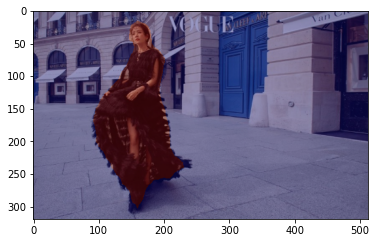

In [33]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 10-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기


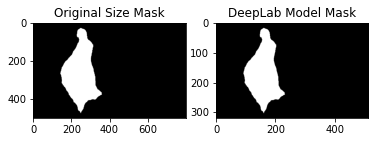

In [34]:
# DeepLab모델을 사용하기 위해 이미지 크기를 작게 resize했음. 따라서 출력도 resize된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
# 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻음
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

# 10-6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

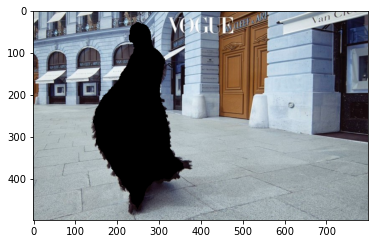

In [35]:
# 배경을 흐리게 하기 위해 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

# bitwise_not 함수를 이용하면 이미지가 반전됨
# 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.



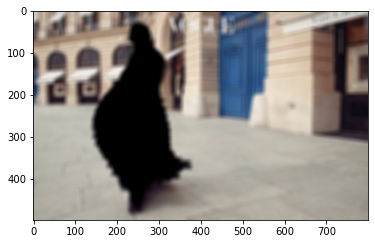

In [36]:
# 위 이미지를 불러와 배경이 흐리게 처리된 영상을 얻을 수 있음 

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 10-7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

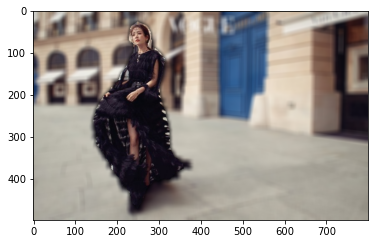

In [37]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# !pip install opencv-python

In [14]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # 웹에서 데이터를 다운바등ㄹ 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [15]:
# 준비한 이미지 불러오기

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/h2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(999, 800, 3)


# 10-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
  
세그메테이션 문제에는 FCN, SegNet, U-Net등 많은 모델이 사용됨. 그중 DeepLab을 사용해서 만들 것  
DeepLab알고리즘(DeepLab v3+)는 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있음
https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

In [16]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
# preprocess() 전처리, run() 실제로 세그멘테이션하는 함수
# 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리함
# 모델이 받는 입력 크기가 정해져있으므로 이에 따라 적절한 크기로 resize하고 OpenCV의 디폴트 BGR채널순서를 탠서플로우에 맞는 RGB로 수정
# 전처리 된 이미지는 run() 함수에서 사용되는 것을 볼 수 있음

In [17]:
# 사전에 학습된 가중치(pretrained weight)를 불러 옵니다. 구글에서 제공하는 파일을 다운로드 하겠습니다. 
# "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있으니 당황하지마세요!

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj47/aiffel/human_segmentation/models
model loaded successfully!


### 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션(watershed segmentation)
  
이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것.  
경계를 나누는 방법은 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가지는데 이때 픽셀 값을 이용해 높고 낮음을 구분할 수 있음.  
낮은 부분부터 서서히 '물'을 채워나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생긴다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게됨


In [18]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(999, 800, 3) (513, 410, 3) 15


In [19]:
# 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)



21

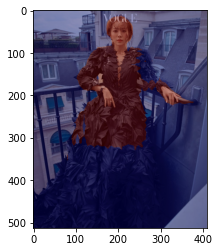

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 10-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기


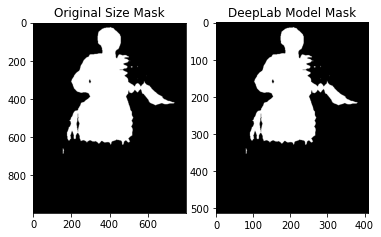

In [21]:
# DeepLab모델을 사용하기 위해 이미지 크기를 작게 resize했음. 따라서 출력도 resize된 입력 크기와 같게 나오게 됨
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
# 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻음
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

# 10-6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

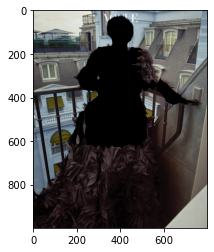

In [22]:
# 배경을 흐리게 하기 위해 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

# bitwise_not 함수를 이용하면 이미지가 반전됨
# 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.



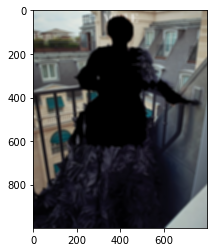

In [23]:
# 위 이미지를 불러와 배경이 흐리게 처리된 영상을 얻을 수 있음 

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 10-7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

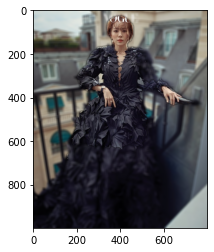

In [24]:
# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

Step 1. 인물모드 직접 해 보기

여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

Step 2. 사진에서 문제점 찾기

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

Step 3. 해결 방법을 제안해 보기

아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼만한 주제를 아래에 몇가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

참고자료 : https://ggyul.tistory.com/12

3D Depth Camera 활용하기
카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

참고자료 : https://m.blog.naver.com/panoptics/221336152952

깊이 영상(Depth image) 활용하기
하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

참고자료 : https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
참고자료 : https://sites.google.com/view/struct2depth


IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

참고자료 : https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html

엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

# 총평

1. 인물모드 사진을 성공적으로 제작하였다.
- 노드를 따라하니 추가 사진을 하는 것은 크게 문제되지 않았다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
- 인물 경계선 쪽으로 블러가 덜 적용되는 부분이 있다.
- 옷이 배경과 비슷한? 경우에는 블러가 정확히 적용이 안된다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
- 아직 개선할 수 있는 솔루션을 제공하기에는 내 실력이 부족한 것 같다...